In [1]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
from numpy import linalg as LA
from ROOT import TLorentzVector
from array import array
# import PyTEX
import os

import math
import random
from optparse import OptionParser

sys.path.append('/storage/user/jmao/gpu/jmao/cms-llp/delayed_jet_analyzer/lib/')

from histo_utilities import create_TH1D, create_TH2D, create_TGraph,std_color_list, make_ratio_plot

import CMS_lumi, tdrstyle 
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

     
print(sys.version)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import pandas as pd
import pickle as pickle
import shlex
import uproot
import seaborn as sns

from scipy.spatial.distance import cdist
from collections import Counter 
import datetime
import pytz

from prettytable import PrettyTable
from pyjet import cluster

import xgboost as xgb
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier


Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [31]:
# root settings
rt.gROOT.SetBatch(True)
rt.gStyle.SetOptStat(0)
rt.gStyle.SetOptFit(111)
rt.gStyle.SetPaintTextFormat("2.1f")

# plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["text.usetex"] = False
plt.rcParams["mathtext.fontset"] = "cm"

# test_name = 'xgb_HH_vs_QCD_ebBDT'

lumi_sf_sig = 137.0 # scale lumi from sample to full run2
lumi_sf_bkg = 137.0

#output dir
 

# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200901/v1/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200901/v2/'
plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200901/v3/'

os.system("mkdir -p "+ plotDir)

0

# Signal Part

In [32]:
# home_dir = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v14/MC_Fall18/normalized/'
home_dir = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v14/MC_Fall18/1pb_normalized/'

mHs = np.array([400, 600, 1000, 1500, 2000])
# mHs = np.array([200, 400, 600, 1000, 1500, 2000])
# mHs = np.array(['200', '400', '600', '1000', '1500', '2000'])

mXs = {}
mXs['200'] = np.array([25, 50])
mXs['400'] = np.array([50, 100])
mXs['600'] = np.array([50, 150])
mXs['1000'] = np.array([150, 400])
mXs['1500'] = np.array([200, 500])
mXs['2000'] = np.array([250, 600])

# ctaus = np.array([500, 1000, 2000, 5000, 10000]) #mm
ctaus = np.array([1000]) #mm

fnames = {}

for mH in mHs:
    print(mH)
    H = str(mH)
#     print(mXs[H])
    for mX in mXs[H]:
        print(mX)
        X = str(mX)
        for ctau in ctaus:
            print(ctau)
            ct = str(ctau)
            tag = 'm'+H+'_m'+X+'_ctau'+ct
            print(tag)
            fnames[tag] = home_dir+'GluGluH2_H2ToSSTobbbb_MH-'+H+'_MS-'+X+'_ctauS-'+ct+'_TuneCP5_13TeV-pythia8_PRIVATE-MC_1pb_weighted.root'
#             print(fnames[tag])
            
    

400
50
1000
m400_m50_ctau1000
100
1000
m400_m100_ctau1000
600
50
1000
m600_m50_ctau1000
150
1000
m600_m150_ctau1000
1000
150
1000
m1000_m150_ctau1000
400
1000
m1000_m400_ctau1000
1500
200
1000
m1500_m200_ctau1000
500
1000
m1500_m500_ctau1000
2000
250
1000
m2000_m250_ctau1000
600
1000
m2000_m600_ctau1000


In [33]:
NEvents = {}
tree = {}
for k,v in fnames.items():
    print (k, v)
    root_dir = uproot.open(v) 
    tree[k] = root_dir['SusyLLPTree']
    NEvents[k] = root_dir['NEvents'][1]
    a = tree[k]["weight"].array()

m400_m50_ctau1000 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v14/MC_Fall18/1pb_normalized/GluGluH2_H2ToSSTobbbb_MH-400_MS-50_ctauS-1000_TuneCP5_13TeV-pythia8_PRIVATE-MC_1pb_weighted.root
m400_m100_ctau1000 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v14/MC_Fall18/1pb_normalized/GluGluH2_H2ToSSTobbbb_MH-400_MS-100_ctauS-1000_TuneCP5_13TeV-pythia8_PRIVATE-MC_1pb_weighted.root
m600_m50_ctau1000 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v14/MC_Fall18/1pb_normalized/GluGluH2_H2ToSSTobbbb_MH-600_MS-50_ctauS-1000_TuneCP5_13TeV-pythia8_PRIVATE-MC_1pb_weighted.root
m600_m150_ctau1000 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v14/MC_Fall18/1pb_normalized/GluGluH2_H2ToSSTobbbb_MH-600_MS-150_ctauS-1000_TuneCP5_13TeV-pythia8_PRIVATE-MC_1pb_weighted.root
m1000_m150_ctau1000 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnaly

# 0 lep region

In [34]:
trg_path=310
njet_cut=-1
met_cut=200
mdphi_cut=0.5
veto=1

# jet_eta_cut=2.4
jet_eta_cut=1.48
jet_pt_cut=30
jet_time_cut=-1
jet_phoef_cut=0.8
jet_muef_cut=0.6
jet_eleef_cut=0.6


trg_jet_met = {}
trg_jet_nj = {}
trg_jet_mt = {}
trg_jet_ht = {}
trg_jet_mdphi = {}
trg_jet_w = {} 
trg_jet_puw = {} 

trg_jet_pt = {}
trg_jet_eta = {}
trg_jet_e = {}
trg_jet_phi = {}

trg_jet_chef = {}
trg_jet_muef = {}
trg_jet_eleef = {}
trg_jet_phoef = {}

trg_jet_nhef = {}
trg_jet_cemef = {}
trg_jet_nemef = {}

trg_jet_tmf = {}
trg_jet_dr = {}
trg_jet_time = {}

trg_jet_csv = {}

jet_csv_cut=0.5803
trg_jet_csvl = {}
trg_jet_nb = {}

ECAL_R=129.0 #cm
EB_Z=268.3 #cm
trg_jet_ctau = {}
trg_jet_eb = {}
trg_jet_tagged = {}

for k,v in tree.items():
    print(k,v)

    # branches
    met = v['met'].array()
#     mt = v['MT_'].array()
    ht = v['HT'].array()
#     mdphi = v['jetMet_dPhi'].array()
    mdphi = v['jetMet_dPhiMin'].array()
    hlt = v['HLTDecision'].array()[:,trg_path]
    nj = v['nJets'].array()
    nlep = v['nLeptons'].array()
    nmu = v['nMuons'].array()
    nele = v['nElectrons'].array()
    ntau = v['nTaus'].array()
    npho = v['nPhotons'].array()
    
#     llp_r = v['gLLP_decay_vertex_r'].array()
#     llp_z = v['gLLP_decay_vertex_z'].array()
    llp_tagged = v['gLLP_tagged'].array()
    llp_eb = v['gLLP_eb'].array()
    llp_ctau = v['gLLP_ctau'].array()
    
#     
    
    #flags
    flag1 =  v['Flag2_globalSuperTightHalo2016Filter'].array()
#     flag2 =  v['Flag2_globalTightHalo2016Filter'].array() 
#     flag3 =  v['Flag2_goodVertices'].array()
#     flag4 =  v['Flag2_BadChargedCandidateFilter'].array() 
    flag5 =  v['Flag2_BadPFMuonFilter'].array() 
    flag6 =  v['Flag2_EcalDeadCellTriggerPrimitiveFilter'].array() 
    flag7 =  v['Flag2_HBHENoiseFilter'].array() 
    flag8 =  v['Flag2_HBHEIsoNoiseFilter'].array() 
    flag9 =  v['Flag2_ecalBadCalibFilter'].array() 
    flag10 =  v['Flag2_eeBadScFilter'].array() 
    
    #jet var
    pt = v['jetPt'].array()
    eta = v['jetEta'].array()
    e = v['jetE'].array()
    phi = v['jetPhi'].array()
    
    chef = v['jetChargedHadronEnergyFraction'].array()
    muef = v['jetMuonEnergyFraction'].array()
    eleef = v['jetElectronEnergyFraction'].array()
    phoef = v['jetPhotonEnergyFraction'].array()
    
#     nhef = v['jetNeutralHadronEnergyFraction'].array()
#     cemef = v['jetNeutralEMEnergyFraction'].array()
#     nemef = v['jetNeutralEMEnergyFraction'].array()
 
    tmf = v['jetGammaMax_ET'].array()
    dr = v['jetMinDeltaRPVTracks'].array()
    time = v['jetTime'].array()
    
    csv = v['jetCSV'].array()

    weight = v['weight'].array()
    
    #pileup weights
#     if 'background' in k:
    if 'Data' not in k:
        PUweight = v['pileupWeight'].array()
        
    
    print(weight.shape)
    
    #selection
    
    sel_hlt_triggered = 1
    sel_hlt_str  = np.logical_and(sel_hlt_triggered, hlt)
    
    sel_flag_str = np.logical_and(flag1, flag5)
    sel_flag_str = np.logical_and(sel_flag_str, flag6)
    sel_flag_str = np.logical_and(sel_flag_str, flag7)
    sel_flag_str = np.logical_and(sel_flag_str, flag8)
    if '2016' not in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag9)
    if 'Data' in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag10)

    basic_met_str = np.logical_and(nj>njet_cut, met>met_cut)    
    basic_met_str = np.logical_and(basic_met_str, pt.count()>njet_cut)
    basic_met_str = np.logical_and(basic_met_str, nlep==0)
    
    if veto==1:
        basic_met_str = np.logical_and(basic_met_str, nmu==0)
        basic_met_str = np.logical_and(basic_met_str, nele==0)
        basic_met_str = np.logical_and(basic_met_str, ntau==0)
        basic_met_str = np.logical_and(basic_met_str, npho==0)
    
    basic_jet_str = np.logical_and(abs(eta)<jet_eta_cut, pt>jet_pt_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, time>jet_time_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, phoef<jet_phoef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, muef<jet_muef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, eleef<jet_eleef_cut)   

    met_trg_str = np.logical_and(basic_met_str, sel_hlt_str)
    met_trg_str = np.logical_and(basic_met_str, sel_flag_str)
#     if 'H(bb)' in k:
#         met_trg_str = np.logical_and(basic_met_str, np.sum(llp_eb,axis = 1) > 0) 

    
    #apply sel
    trg_jet_met[k] = met[met_trg_str]
    trg_jet_ht[k] = ht[met_trg_str]
    trg_jet_mdphi[k] = mdphi[met_trg_str]
    trg_jet_nj[k] = nj[met_trg_str]
    trg_jet_w[k] = weight[met_trg_str]
#     if 'background' in k:
    if 'Data' not in k:
        trg_jet_puw[k] = PUweight[met_trg_str]
    trg_jet_ctau[k] = llp_ctau[met_trg_str]
    trg_jet_eb[k] = llp_eb[met_trg_str]
    trg_jet_tagged[k] = llp_tagged[met_trg_str]
        

    trg_jet_pt[k] = pt[basic_jet_str][met_trg_str]
    trg_jet_phi[k] = phi[basic_jet_str][met_trg_str]
    trg_jet_eta[k] = eta[basic_jet_str][met_trg_str]
    trg_jet_e[k] = e[basic_jet_str][met_trg_str]

#     trg_jet_nhm[k] = nhm[basic_jet_str][met_trg_str]
#     trg_jet_chm[k] = chm[basic_jet_str][met_trg_str]
#     trg_jet_mum[k] = mum[basic_jet_str][met_trg_str]
#     trg_jet_elem[k] = elem[basic_jet_str][met_trg_str]
#     trg_jet_phom[k] = phom[basic_jet_str][met_trg_str]
    
#     trg_jet_nhef[k] = nhef[basic_jet_str][met_trg_str]
    trg_jet_chef[k] = chef[basic_jet_str][met_trg_str]
    trg_jet_muef[k] = muef[basic_jet_str][met_trg_str]
    trg_jet_eleef[k] = eleef[basic_jet_str][met_trg_str]
    trg_jet_phoef[k] = phoef[basic_jet_str][met_trg_str]
    
#     trg_jet_csv[k] = csv[basic_jet_str][met_trg_str]
    
#     trg_jet_nrec[k] = nrec[basic_jet_str][met_trg_str]
    trg_jet_time[k] = time[basic_jet_str][met_trg_str]
    trg_jet_dr[k] = dr[basic_jet_str][met_trg_str]
    trg_jet_tmf[k] = tmf[basic_jet_str][met_trg_str]
#     trg_jet_amax[k] = amax[basic_jet_str][met_trg_str]

    trg_jet_csv[k] = csv[basic_jet_str][met_trg_str]

    #clean up
    trg_jet_met[k] = trg_jet_met[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_ht[k] = trg_jet_ht[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_mdphi[k] = trg_jet_mdphi[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_nj[k] = trg_jet_nj[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_w[k] = trg_jet_w[k][trg_jet_pt[k].count()>njet_cut]
#     if 'background' in k:
    if 'Data' not in k:
        trg_jet_puw[k] = trg_jet_puw[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_ctau[k] = trg_jet_ctau[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_eb[k] = trg_jet_eb[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_tagged[k] = trg_jet_tagged[k][trg_jet_pt[k].count()>njet_cut]

    trg_jet_phi[k] = trg_jet_phi[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_eta[k] = trg_jet_eta[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_e[k] = trg_jet_e[k][trg_jet_pt[k].count()>njet_cut]

#     trg_jet_nhm[k] = trg_jet_nhm[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_chm[k] = trg_jet_chm[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_mum[k] = trg_jet_mum[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_elem[k] = trg_jet_elem[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_phom[k] = trg_jet_phom[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_nhef[k] = trg_jet_nhef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_chef[k] = trg_jet_chef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_muef[k] = trg_jet_muef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_eleef[k] = trg_jet_eleef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_phoef[k] = trg_jet_phoef[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_csv[k] = trg_jet_csv[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_nrec[k] = trg_jet_nrec[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_time[k] = trg_jet_time[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_dr[k] = trg_jet_dr[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_tmf[k] = trg_jet_tmf[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_amax[k] = trg_jet_amax[k][trg_jet_pt[k].count()>njet_cut]

    trg_jet_csv[k] = trg_jet_csv[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_csvl[k] = trg_jet_csv[k][trg_jet_csv[k]>jet_csv_cut]
    trg_jet_nb[k] = trg_jet_csvl[k].count()

    trg_jet_pt[k] = trg_jet_pt[k][trg_jet_pt[k].count()>njet_cut]

    #print out check


    print(len(trg_jet_w[k]))
    print(len(trg_jet_puw[k]))
    print(len(trg_jet_pt[k]))
    print(len(trg_jet_ctau[k]))
    print(len(trg_jet_eb[k]))
    print(len(trg_jet_tagged[k]))
#     print(trg_jet_ctau[k][:10])
#     print(trg_jet_eb[k][:10])

    

m400_m50_ctau1000 <TTree b'SusyLLPTree' at 0x7f2be2200518>
(5562,)
4734
4734
4734
4734
4734
4734
m400_m100_ctau1000 <TTree b'SusyLLPTree' at 0x7f2bdc14b160>
(3157,)
2722
2722
2722
2722
2722
2722
m600_m50_ctau1000 <TTree b'SusyLLPTree' at 0x7f2bdbe71160>
(11942,)
10215
10215
10215
10215
10215
10215
m600_m150_ctau1000 <TTree b'SusyLLPTree' at 0x7f2bdb579978>
(6419,)
5535
5535
5535
5535
5535
5535
m1000_m150_ctau1000 <TTree b'SusyLLPTree' at 0x7f2bdaffc198>
(14674,)
12129
12129
12129
12129
12129
12129
m1000_m400_ctau1000 <TTree b'SusyLLPTree' at 0x7f2bda47b128>
(3079,)
2377
2377
2377
2377
2377
2377
m1500_m200_ctau1000 <TTree b'SusyLLPTree' at 0x7f2bda1179b0>
(15581,)
12467
12467
12467
12467
12467
12467
m1500_m500_ctau1000 <TTree b'SusyLLPTree' at 0x7f2bd9472c50>
(8478,)
6318
6318
6318
6318
6318
6318
m2000_m250_ctau1000 <TTree b'SusyLLPTree' at 0x7f2bd8c3ad30>
(13733,)
10801
10801
10801
10801
10801
10801
m2000_m600_ctau1000 <TTree b'SusyLLPTree' at 0x7f2bd80d6828>
(10799,)
7912
7912
7912
79

# Tags

In [35]:
# time_cut = 0.08676443430239597
# tmf_cut = 0.16335152541277656 
# dr_cut = 0.06402562462487048
# chef_cut = 0.061590940809278155

time_cut = 0.09
tmf_cut = 0.16 
dr_cut = 0.06 
chef_cut = 0.06 

nTags = {}
nJets = {}

tag_jet_pt = {}
tag_jet_eta = {}
tag_jet_phi = {}
tag_jet_e = {}

tag_jet_chef = {}
tag_jet_tmf = {}
tag_jet_time = {}
tag_jet_dr = {}

tag_jet_phoef = {}
tag_jet_eleef = {}
tag_jet_muef = {}

untag_jet_pt = {}
untag_jet_eta = {}
untag_jet_phi = {}
untag_jet_e = {}

untag_jet_chef = {}
untag_jet_tmf = {}
untag_jet_time = {}
untag_jet_dr = {}

untag_jet_phoef = {}
untag_jet_eleef = {}
untag_jet_muef = {}

for k,v in tree.items():
    print(k,v)
    
    nJets[k] = trg_jet_pt[k].count()
    
    #tag cuts
    tagged_jet = np.logical_and(trg_jet_tmf[k]<tmf_cut, trg_jet_dr[k]>dr_cut)
    tagged_jet = np.logical_and(tagged_jet, trg_jet_time[k]>time_cut)
    tagged_jet = np.logical_and(tagged_jet, trg_jet_chef[k]<chef_cut) 
    
    untagged_jet = np.logical_not(tagged_jet) 
    
    nTags[k] = trg_jet_pt[k][tagged_jet].count()
    
    tag_jet_pt[k] = trg_jet_pt[k][tagged_jet] 
    tag_jet_eta[k] = trg_jet_eta[k][tagged_jet] 
    tag_jet_e[k] = trg_jet_e[k][tagged_jet] 
    tag_jet_phi[k] = trg_jet_phi[k][tagged_jet]
    
    tag_jet_chef[k] = trg_jet_chef[k][tagged_jet] 
    tag_jet_tmf[k] = trg_jet_tmf[k][tagged_jet] 
    tag_jet_time[k] = trg_jet_time[k][tagged_jet] 
    tag_jet_dr[k] = trg_jet_dr[k][tagged_jet] 
    
    tag_jet_phoef[k] = trg_jet_phoef[k][tagged_jet] 
    tag_jet_muef[k] = trg_jet_muef[k][tagged_jet] 
    tag_jet_eleef[k] = trg_jet_eleef[k][tagged_jet] 
    
    untag_jet_pt[k] = trg_jet_pt[k][untagged_jet] 
    untag_jet_eta[k] = trg_jet_eta[k][untagged_jet] 
    untag_jet_e[k] = trg_jet_e[k][untagged_jet] 
    untag_jet_phi[k] = trg_jet_phi[k][untagged_jet]
    
    untag_jet_chef[k] = trg_jet_chef[k][untagged_jet] 
    untag_jet_tmf[k] = trg_jet_tmf[k][untagged_jet] 
    untag_jet_time[k] = trg_jet_time[k][untagged_jet] 
    untag_jet_dr[k] = trg_jet_dr[k][untagged_jet] 
    
    untag_jet_phoef[k] = trg_jet_phoef[k][untagged_jet] 
    untag_jet_muef[k] = trg_jet_muef[k][untagged_jet] 
    untag_jet_eleef[k] = trg_jet_eleef[k][untagged_jet] 
    
    print(trg_jet_pt[k][:10])
    print(tag_jet_pt[k][:10])
    print(untag_jet_pt[k][:10])
    
    print(np.unique(nJets[k]))
    print(np.unique(nTags[k]))
    
    for i,ele in enumerate(nTags[k]):
        if ele > 2:
            nTags[k][i] = 2
            
    print(np.unique(nTags[k]))
    

m400_m50_ctau1000 <TTree b'SusyLLPTree' at 0x7f2be2200518>
[[107.21049] [159.31024] [] ... [129.46638 118.60639] [382.11075] []]
[[107.21049] [] [] ... [] [] []]
[[] [159.31024] [] ... [129.46638 118.60639] [382.11075] []]
[0 1 2 3 4 5 6 7]
[0 1 2]
[0 1 2]
m400_m100_ctau1000 <TTree b'SusyLLPTree' at 0x7f2bdc14b160>
[[347.49545] [86.59498] [337.6477 35.37546 30.464823] ... [] [170.23524 54.720257] [142.50832 124.7084]]
[[] [] [] ... [] [] []]
[[347.49545] [86.59498] [337.6477 35.37546 30.464823] ... [] [170.23524 54.720257] [142.50832 124.7084]]
[0 1 2 3 4 5 6 7]
[0 1 2]
[0 1 2]
m600_m50_ctau1000 <TTree b'SusyLLPTree' at 0x7f2bdbe71160>
[[69.22113] [305.77133 54.871582] [80.62259 56.839024] ... [276.9763] [48.484776] [231.93483 63.86296 53.401596]]
[[] [] [] ... [] [] []]
[[69.22113] [305.77133 54.871582] [80.62259 56.839024] ... [276.9763] [48.484776] [231.93483 63.86296 53.401596]]
[0 1 2 3 4 5 6 7 8]
[0 1 2]
[0 1 2]
m600_m150_ctau1000 <TTree b'SusyLLPTree' at 0x7f2bdb579978>
[[285.75

# Signal Yields

In [36]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'Weight' , 'Bin 2 Yield', 'Bin 2 Error'])
for k,v in tree.items():
#     print(k)
 
    lumi=137000
    EventW = [x*y for x,y in zip(trg_jet_w[k][nTags[k]==2],trg_jet_puw[k][nTags[k]==2])]
#     print(np.sum(EventW)*lumi)
#     print(len(EventW))
#     print(len(trg_jet_w[k][nTags[k]==2]))
#     row = [k, np.unique(trg_jet_w[k]) ,round(np.sum(trg_jet_w[k][nTags[k]==2])*lumi, 2), round(math.sqrt(np.sum(trg_jet_w[k][nTags[k]==2])*lumi), 2) ]
    row = [k, np.unique(trg_jet_w[k]) ,round(np.sum(EventW)*lumi, 2), round(math.sqrt(np.sum(EventW)*lumi), 2) ]
    table.add_row(row)
        
print(table)



======================= Summary ==============================
+---------------------+-----------------+-------------+-------------+
|        Sample       |      Weight     | Bin 2 Yield | Bin 2 Error |
+---------------------+-----------------+-------------+-------------+
|  m400_m50_ctau1000  |     [2.e-05]    |    11.87    |     3.45    |
|  m400_m100_ctau1000 |     [2.e-05]    |    99.69    |     9.98    |
|  m600_m50_ctau1000  |     [2.e-05]    |    11.67    |     3.42    |
|  m600_m150_ctau1000 |     [2.e-05]    |    707.88   |    26.61    |
| m1000_m150_ctau1000 |     [2.e-05]    |    1169.6   |     34.2    |
| m1000_m400_ctau1000 | [2.0003201e-05] |   1274.58   |     35.7    |
| m1500_m200_ctau1000 | [2.0004802e-05] |   1597.75   |    39.97    |
| m1500_m500_ctau1000 | [2.0219994e-05] |   6042.75   |    77.74    |
| m2000_m250_ctau1000 | [2.0370333e-05] |   1729.29   |    41.58    |
| m2000_m600_ctau1000 | [2.3789133e-05] |   10473.11  |    102.34   |
+---------------------+--

In [37]:
table_txt = table.get_string()
with open(plotDir+'/SignalSummaryTableBin2Rebin.txt','w') as file:
    file.write(table_txt)

# Reweight CTAU

In [38]:
def weight_calc(llp_ct, new_ctau, old_ctau):
    source = np.exp(-1.0*llp_ct/old_ctau)/old_ctau**2
    weight = 1.0/new_ctau**2 * np.exp(-1.0*llp_ct/new_ctau)/source
    return weight

In [32]:
# mHs = np.array([200, 400, 600, 1000, 1500, 2000])

# mXs = {}
# # mXs['200'] = np.array([25, 50])
# mXs['200'] = np.array([50])
# mXs['400'] = np.array([50, 100])
# mXs['600'] = np.array([50, 150])
# mXs['1000'] = np.array([150, 400])
# mXs['1500'] = np.array([200, 500])
# mXs['2000'] = np.array([250, 600])

# old_ctaus = {}
# old_ctaus['200'] = np.array([2000]) #mm
# old_ctaus['400'] = np.array([500, 1000, 2000, 5000, 10000]) #mm
# old_ctaus['600'] = np.array([500, 1000, 2000, 5000, 10000]) #mm
# old_ctaus['1000'] = np.array([500, 1000, 2000, 5000, 10000]) #mm
# old_ctaus['1500'] = np.array([500, 1000, 2000, 5000, 10000]) #mm
# old_ctaus['2000'] = np.array([500, 1000, 2000, 5000, 10000]) #mm


# for mH in mHs:
# #     print(mH)
#     H = str(mH)
# #     print(mXs[H])
#     for mX in mXs[H]:
# #         print(mX)
#         X = str(mX)
#         for ctau in ctaus:
# #             print(ctau)
#             ct = str(ctau)
#             old_tag = 'm'+H+'_m'+X+'_ctau'+ct
#             print(old_tag)
            

In [39]:
old_bin2 = {}
old_bin2err = {}

lumi=137000

for mH in mHs:
    H = str(mH)
    old_bin2[H] = {}
    old_bin2err[H] = {}
    for mX in mXs[H]:
        X = str(mX)
        old_bin2[H][X] = {}
        old_bin2err[H][X] = {}
        for ctau in ctaus:
            ct = str(ctau)
            tag = 'm'+H+'_m'+X+'_ctau'+ct
            EventW = [x*y for x,y in zip(trg_jet_w[tag][nTags[tag]==2],trg_jet_puw[tag][nTags[tag]==2])]
            old_bin2[H][X][ct] = np.sum(EventW)*lumi
            old_bin2err[H][X][ct] = math.sqrt(np.sum(EventW)*lumi)
            

In [40]:
print(old_bin2)

{'400': {'50': {'1000': 11.874437826918438}, '100': {'1000': 99.69433536753058}}, '600': {'50': {'1000': 11.666659556794912}, '150': {'1000': 707.8786166384816}}, '1000': {'150': {'1000': 1169.5992453023791}, '400': {'1000': 1274.579619988799}}, '1500': {'200': {'1000': 1597.7494828402996}, '500': {'1000': 6042.753081768751}}, '2000': {'250': {'1000': 1729.2863056063652}, '600': {'1000': 10473.111763596535}}}


In [41]:
old_ctaus = {}

for mH in mHs:
    H = str(mH)
    old_ctaus[H] = {}
    for mX in mXs[H]:
        X = str(mX)
        print(H, X, old_bin2[H][X])
        old_ctaus[H][X] = []
        for i, ctau in enumerate(old_bin2[H][X]):
#             print(i, ctau, old_bin2[H][X][ctau])
            if old_bin2[H][X][ctau] > 0:
                old_ctaus[H][X].append(int(ctau))
        print(old_ctaus[H][X])
   

400 50 {'1000': 11.874437826918438}
[1000]
400 100 {'1000': 99.69433536753058}
[1000]
600 50 {'1000': 11.666659556794912}
[1000]
600 150 {'1000': 707.8786166384816}
[1000]
1000 150 {'1000': 1169.5992453023791}
[1000]
1000 400 {'1000': 1274.579619988799}
[1000]
1500 200 {'1000': 1597.7494828402996}
[1000]
1500 500 {'1000': 6042.753081768751}
[1000]
2000 250 {'1000': 1729.2863056063652}
[1000]
2000 600 {'1000': 10473.111763596535}
[1000]


In [42]:
     
new_ctaus=np.array([1, 3, 5, 7, 10, 30, 40, 50, 60, 80, 100, 
                200, 300, 400, 500, 600, 700, 800, 900, 950, 980, 1000, 
                1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000, 5000,
                10000, 20000, 30000, 50000, 100000])


lumi = 137000

Bin2Calc = {}

for mH in mHs:
    H = str(mH)
    for mX in mXs[H]:
        X = str(mX)
        for new_ctau in new_ctaus:
            new_ct = str(new_ctau)
            new_tag = 'm'+H+'_m'+X+'_ctau'+new_ct
            
            Bin2Calc[new_tag] = False



OLD_CTAUS = {}

for mH in mHs:
    H = str(mH)
    OLD_CTAUS[H] = {}
    for mX in mXs[H]:
        X = str(mX)
        OLD_CTAUS[H][X] = {}
        for new_ctau in new_ctaus:
            new_ct = str(new_ctau)
            new_tag = 'm'+H+'_m'+X+'_ctau'+new_ct

            if len(old_ctaus[H][X])==1:
                OLD_CTAUS[H][X][new_ct] = int(np.unique(old_ctaus[H][X]))
                Bin2Calc[new_tag] = True
            else:
                for old_ctau in old_ctaus[H][X]:
                    if new_ctau == old_ctau:
                            OLD_CTAUS[H][X][new_ct] = old_ctau
                            Bin2Calc[new_tag] = True
                    elif new_ctau < old_ctau:
#                         print(Bin2Calc[new_tag])
                        if not Bin2Calc[new_tag]:
                            OLD_CTAUS[H][X][new_ct] = old_ctau
                            Bin2Calc[new_tag] = True
                    elif max(old_ctaus[H][X]) < max(new_ctaus):
                        if not Bin2Calc[new_tag]:
                            if new_ctau > max(old_ctaus[H][X]):
                                OLD_CTAUS[H][X][new_ct] = max(old_ctaus[H][X])
                                Bin2Calc[new_tag] = True

In [43]:
# print(OLD_CTAUS)
for mH in mHs:
    H = str(mH)
    for mX in mXs[H]:
        X = str(mX)
        # print to check
        print(H, X, old_bin2[H][X])
        print(old_ctaus[H][X])
        print(OLD_CTAUS[H][X])

400 50 {'1000': 11.874437826918438}
[1000]
{'1': 1000, '3': 1000, '5': 1000, '7': 1000, '10': 1000, '30': 1000, '40': 1000, '50': 1000, '60': 1000, '80': 1000, '100': 1000, '200': 1000, '300': 1000, '400': 1000, '500': 1000, '600': 1000, '700': 1000, '800': 1000, '900': 1000, '950': 1000, '980': 1000, '1000': 1000, '1100': 1000, '1200': 1000, '1300': 1000, '1400': 1000, '1500': 1000, '2000': 1000, '3000': 1000, '4000': 1000, '5000': 1000, '10000': 1000, '20000': 1000, '30000': 1000, '50000': 1000, '100000': 1000}
400 100 {'1000': 99.69433536753058}
[1000]
{'1': 1000, '3': 1000, '5': 1000, '7': 1000, '10': 1000, '30': 1000, '40': 1000, '50': 1000, '60': 1000, '80': 1000, '100': 1000, '200': 1000, '300': 1000, '400': 1000, '500': 1000, '600': 1000, '700': 1000, '800': 1000, '900': 1000, '950': 1000, '980': 1000, '1000': 1000, '1100': 1000, '1200': 1000, '1300': 1000, '1400': 1000, '1500': 1000, '2000': 1000, '3000': 1000, '4000': 1000, '5000': 1000, '10000': 1000, '20000': 1000, '30000':

In [44]:
Bin2Sig = {}
Bin2SigErr = {}
NEW_CTAUS = {}
for mH in mHs:
    H = str(mH)
    NEW_CTAUS[H] = {}
    for mX in mXs[H]:
        X = str(mX)
        NEW_CTAUS[H][X] = []
        for new_ctau in new_ctaus:
            new_ct = str(new_ctau)
            new_tag = 'm'+H+'_m'+X+'_ctau'+new_ct

            ctau = OLD_CTAUS[H][X][new_ct] 
            old_tag = 'm'+H+'_m'+X+'_ctau'+str(ctau)
 
            ctau_calc =  np.array([x[0]+x[1] for x in trg_jet_ctau[old_tag][nTags[old_tag]==2] ])
            weight_ctau = weight_calc( ctau_calc, float(new_ctau)/10, ctau/10) # convert everything to cm
            EventReW = [x*y for x,y in zip(EventW,weight_ctau)]

            Bin2Sig[new_tag] = np.sum(EventReW)*lumi
            Bin2SigErr[new_tag] = math.sqrt(np.sum(EventReW)*lumi)

            print(new_tag, Bin2Sig[new_tag])
            
            if Bin2Sig[new_tag] > 0.01:
                NEW_CTAUS[H][X].append(new_ctau)
                        
                    
                

m400_m50_ctau1 0.0
m400_m50_ctau3 0.0
m400_m50_ctau5 0.0
m400_m50_ctau7 0.0
m400_m50_ctau10 1.9197788961249994e-40
m400_m50_ctau30 1.9609165319636237e-11
m400_m50_ctau40 6.071938053265127e-08
m400_m50_ctau50 6.952919882202702e-06
m400_m50_ctau60 0.00015582829560045752
m400_m50_ctau80 0.0069862875307080685
m400_m50_ctau100 0.06397595598173211
m400_m50_ctau200 3.813929766693036
m400_m50_ctau300 11.304190920782275
m400_m50_ctau400 16.84777704940643
m400_m50_ctau500 19.77047062246129
m400_m50_ctau600 21.009953270549886
m400_m50_ctau700 21.321528969565406
m400_m50_ctau800 21.131479894393124
m400_m50_ctau900 20.66493073652964
m400_m50_ctau950 20.36840681103058
m400_m50_ctau980 20.176384059595875
m400_m50_ctau1000 20.043565615196712
m400_m50_ctau1100 19.33701543021016
m400_m50_ctau1200 18.587616534205154
m400_m50_ctau1300 17.822394336690195
m400_m50_ctau1400 17.059109930414706
m400_m50_ctau1500 16.309537590132095
m400_m50_ctau2000 12.955198028066661
m400_m50_ctau3000 8.390214417886455
m400_m5

In [46]:
for mH in mHs:
    H = str(mH)
    for mX in mXs[H]:
        X = str(mX)
        print(H,X, NEW_CTAUS[H][X])

400 50 [100, 200, 300, 400, 500, 600, 700, 800, 900, 950, 980, 1000, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000, 5000, 10000, 20000, 30000, 50000, 100000]
400 100 [100, 200, 300, 400, 500, 600, 700, 800, 900, 950, 980, 1000, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000, 5000, 10000, 20000, 30000, 50000, 100000]
600 50 [80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 950, 980, 1000, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000, 5000, 10000, 20000, 30000, 50000, 100000]
600 150 [40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 950, 980, 1000, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000, 5000, 10000, 20000, 30000, 50000, 100000]
1000 150 [30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 950, 980, 1000, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000, 5000, 10000, 20000, 30000, 50000, 100000]
1000 400 [40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 950, 980, 1000, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000, 5000, 10000, 20000, 30000,

In [47]:
# mHs = np.array([200, 400, 600, 1000, 1500, 2000])
mHs = np.array([400, 600, 1000, 1500, 2000])

from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample, Ctau [mm]', 'Bin 2 Yield', 'Bin 2 Error'])
for mH in mHs:
    H = str(mH)
    for mX in mXs[H]:
        X = str(mX)
#         print(H,X, NEW_CTAUS[H][X]) 
        for i, ctau in enumerate(NEW_CTAUS[H][X]):
#             print(i,ctau)
            ct = str(ctau)
            new_tag = 'm'+H+'_m'+X+'_ctau'+ct
            row = [new_tag, round(Bin2Sig[new_tag], 2), round(Bin2SigErr[new_tag], 2) ]
            table.add_row(row)
        
print(table)



======================= Summary ==============================
+-----------------------+-------------+-------------+
|   Sample, Ctau [mm]   | Bin 2 Yield | Bin 2 Error |
+-----------------------+-------------+-------------+
|    m400_m50_ctau100   |     0.06    |     0.25    |
|    m400_m50_ctau200   |     3.81    |     1.95    |
|    m400_m50_ctau300   |     11.3    |     3.36    |
|    m400_m50_ctau400   |    16.85    |     4.1     |
|    m400_m50_ctau500   |    19.77    |     4.45    |
|    m400_m50_ctau600   |    21.01    |     4.58    |
|    m400_m50_ctau700   |    21.32    |     4.62    |
|    m400_m50_ctau800   |    21.13    |     4.6     |
|    m400_m50_ctau900   |    20.66    |     4.55    |
|    m400_m50_ctau950   |    20.37    |     4.51    |
|    m400_m50_ctau980   |    20.18    |     4.49    |
|   m400_m50_ctau1000   |    20.04    |     4.48    |
|   m400_m50_ctau1100   |    19.34    |     4.4     |
|   m400_m50_ctau1200   |    18.59    |     4.31    |
|   m400_m50_ctau

In [48]:
table_txt = table.get_string()
with open(plotDir+'/CTAUSignalSummaryTableBin2Rebin.txt','w') as file:
    file.write(table_txt)

# Make datacards

In [49]:
data_bin2_sum = 2.93
data_bin2_sum_err = 0.78
print('Data sum',data_bin2_sum)
print('Data sum err',data_bin2_sum_err)

Data sum 2.93
Data sum err 0.78


In [50]:
def make_datacard(outDataCardsDir,cardName, sig_yield, bkg_yield, sig_unc, sig_stat, bkg_unc, bkg_pred):
    text_file = open(outDataCardsDir+cardName, "w")
    text_file.write('# Simple counting experiment, with one signal and a few background processes \n')
    text_file.write('# Simplified version of the SUSY LLP analysis for mH = 200 GeV \n')

    text_file.write('imax {0} \n'.format(1))
    text_file.write('jmax {0} \n'.format(1))
    text_file.write('kmax * \n')
    text_file.write('--------------- \n')
    text_file.write('--------------- \n')
    text_file.write('bin \t bin1 \n')
    text_file.write('observation \t {0:6.2f} \n'.format(0))
    text_file.write('------------------------------ \n')  
    text_file.write('bin \t bin1 \t bin1 \n')
    text_file.write('process sig \t bkg \n')
    text_file.write('process 0 \t 1 \n')
    text_file.write('rate \t {0} \t {1} \n'.format(sig_yield, bkg_yield))
    text_file.write('------------------------------ \n')  
 
#     #### uncertainties ####
    text_file.write('------------------------------ \n')  
    text_file.write('lumi\t lnN \t 1.025000 \t - \n')
    text_file.write('signal_yield \t lnN  \t {0:6.6f} \t - \n'.format(1+sig_unc))    
    text_file.write('signal_stat \t lnN  \t {0} \t - \n'.format(1+sig_stat))    
    text_file.write('bkg_yield \t lnN  \t - \t {0:6.6f} \n'.format(1+bkg_unc))    
    text_file.write('bkg_pred \t lnN  \t - \t {0} \n'.format(1+bkg_pred))    

    
    text_file.close()

In [51]:
# DataCardsDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200901/v1/DataCards/'
# DataCardsDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200901/v2/DataCards/'
DataCardsDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200901/v3/DataCards/'

os.system("mkdir -p "+ DataCardsDir)

0

In [52]:
for mH in mHs:
    H = str(mH)
    for mX in mXs[H]:
        X = str(mX)
#         print(H,X, NEW_CTAUS[H][X]) 
        for i, ctau in enumerate(NEW_CTAUS[H][X]):
#             print(i,ctau)
            ct = str(ctau)
            new_tag = 'm'+H+'_m'+X+'_ctau'+ct

            card_name = 'HeavyHiggs_LLP_MH'+H+'_MS'+X+'_ctau'+ct+'.txt'
            if Bin2Sig[new_tag] !=0:
                sig_unc = Bin2SigErr[new_tag] / Bin2Sig[new_tag]
    #             print(sig_unc)
            else:
                sig_unc = 0.2
            sig_stat = 0.2
            bkg_unc = data_bin2_sum_err / data_bin2_sum
            bkg_pred = 0.5
            sig_yield = Bin2Sig[new_tag]
            bkg_yield = data_bin2_sum
            make_datacard(DataCardsDir, card_name, sig_yield, bkg_yield, sig_unc, sig_stat, bkg_unc, bkg_pred)
            print(DataCardsDir+card_name)
 

/storage/user/jmao/gpu/jmao/cms-llp/plots/20200901/v3/DataCards/HeavyHiggs_LLP_MH400_MS50_ctau100.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200901/v3/DataCards/HeavyHiggs_LLP_MH400_MS50_ctau200.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200901/v3/DataCards/HeavyHiggs_LLP_MH400_MS50_ctau300.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200901/v3/DataCards/HeavyHiggs_LLP_MH400_MS50_ctau400.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200901/v3/DataCards/HeavyHiggs_LLP_MH400_MS50_ctau500.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200901/v3/DataCards/HeavyHiggs_LLP_MH400_MS50_ctau600.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200901/v3/DataCards/HeavyHiggs_LLP_MH400_MS50_ctau700.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200901/v3/DataCards/HeavyHiggs_LLP_MH400_MS50_ctau800.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200901/v3/DataCards/HeavyHiggs_LLP_MH400_MS50_ctau900.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200901/v3/DataCards/HeavyHiggs_LLP_MH4

In [53]:
# LimitDir = '/storage/user/jmao/login-1/jmao/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/HeavyHiggs_LLP_V1p17_v1/'
# LimitDir = '/storage/user/jmao/login-1/jmao/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/HeavyHiggs_LLP_V1p17_v2/'
LimitDir = '/storage/user/jmao/login-1/jmao/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/HeavyHiggs_LLP_V1p17_v3/'

os.system("mkdir -p "+ LimitDir)

0

In [54]:
LimitCmd = 'cmds'
file_io = open(LimitDir+LimitCmd, 'w')
long_str=''
for mH in mHs:
    H = str(mH)
    for mX in mXs[H]:
        X = str(mX)
        for i, ctau in enumerate(NEW_CTAUS[H][X]):
            ct = str(ctau)
            new_tag = 'm'+H+'_m'+X+'_ctau'+ct

            card_name = 'HeavyHiggs_LLP_MH'+H+'_MS'+X+'_ctau'+ct+'.txt'
#             print(card_name)
#             print('combine -M AsymptoticLimits '+DataCardsDir+card_name+' -n _HeavyHiggs_LLP_MH'+H+'_MS'+X+'_ctau'+ct+'  --rMin 0.0 --rMax 1.0 -t -1 --expectSignal 0 -m 125  > limit_HeavyHiggs_LLP_MH'+H+'_MS'+X+'_ctau'+ct+'.txt' )
            long_str += 'combine -M AsymptoticLimits '+DataCardsDir+card_name+' -n _HeavyHiggs_LLP_MH'+H+'_MS'+X+'_ctau'+ct+'  --rMin 0.0 --rMax 1.0 -t -1 --expectSignal 0 -m '+H+'  > limit_HeavyHiggs_LLP_MH'+H+'_MS'+X+'_ctau'+ct+'.txt \n' 

file_io.write(long_str)
file_io.close()

# Limit Plots

In [57]:
# LimitPlotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200901/v1/Limits/'
# LimitPlotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200901/v2/Limits/'
LimitPlotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200901/v3/Limits/'

os.system("mkdir -p "+ LimitPlotDir)

0

In [58]:
rtFiles = {}
rtTrees = {}
Limits = {}
LimitErrs = {}
LimitCtaus = {}

for mH in mHs:
    H = str(mH)
    LimitCtaus[H] = {}
    for mX in mXs[H]:
        X = str(mX)
        LimitCtaus[H][X] = []
#         print(H,X, NEW_CTAUS[H][X])     
        for i, ctau in enumerate(NEW_CTAUS[H][X]):
            ct = str(ctau)
            new_tag = 'm'+H+'_m'+X+'_ctau'+ct
#             card_name = 'HeavyHiggs_LLP_MH'+H+'_MS'+X+'_ctau'+ct+'.txt'
            rt_name = 'higgsCombine_HeavyHiggs_LLP_MH'+H+'_MS'+X+'_ctau'+ct+'.AsymptoticLimits.mH'+H+'.root'
    
            rtFiles[new_tag] = LimitDir+rt_name

            root_dir = uproot.open(rtFiles[new_tag])
            rtTrees[new_tag] = root_dir['limit']

            print( "-2\u03C3 , -\u03C3 , exp, +\u03C3 , +2\u03C3 , obs")
            v = rtTrees[new_tag]
            limit = v['limit'].array()
            print(limit)
            print(len(limit))
            limitErr = v['limitErr'].array()
            print(limitErr)
            print(len(limitErr))
            
            if len(limit)==6:
                if len(limitErr)==6:
                    LimitCtaus[H][X].append(ctau)

            Limits[new_tag] = limit
            LimitErrs[new_tag] = limitErr
            

-2σ , -σ , exp, +σ , +2σ , obs
[ 90.625      191.45507812 200.         402.4909668  606.56390381
 560.00892986]
6
[0.         0.         0.         0.         0.         2.10786402]
6
-2σ , -σ , exp, +σ , +2σ , obs
[0.72802734 1.07156527 1.77499998 3.2324965  5.38060141 1.77197606]
6
[0.         0.         0.         0.         0.         0.00543641]
6
-2σ , -σ , exp, +σ , +2σ , obs
[0.23518066 0.33588028 0.52812499 0.89020717 1.5108912  0.52804076]
6
[0.         0.         0.         0.         0.         0.00158128]
6
-2σ , -σ , exp, +σ , +2σ , obs
[0.15646973 0.22138444 0.34531251 0.57104713 0.94900632 0.34485645]
6
[0.         0.         0.         0.         0.         0.00086008]
6
-2σ , -σ , exp, +σ , +2σ , obs
[0.13318177 0.18757144 0.29140624 0.47957861 0.79083979 0.29128383]
6
[0.         0.         0.         0.         0.         0.00056545]
6
-2σ , -σ , exp, +σ , +2σ , obs
[0.12496948 0.17716527 0.2734375  0.45000675 0.73909461 0.27331912]
6
[0.         0.         0.      

In [59]:
for mH in mHs:
    H = str(mH)
    for mX in mXs[H]:
        X = str(mX)
#         LimitCtaus[H][X] = []
        print(H,X, LimitCtaus[H][X])  

400 50 [100, 200, 300, 400, 500, 600, 700, 800, 900, 950, 980, 1000, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000, 5000, 10000, 20000, 30000, 50000]
400 100 [200, 300, 400, 500, 600, 700, 800, 900, 950, 980, 1000, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000, 5000, 10000, 20000, 30000, 50000, 100000]
600 50 [100, 200, 300, 400, 500, 600, 700, 800, 900, 950, 980, 1000, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000, 5000, 10000, 20000, 30000, 50000]
600 150 [40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 950, 980, 1000, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000, 5000, 10000, 20000, 30000, 50000, 100000]
1000 150 [30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 950, 980, 1000, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000, 5000, 10000, 20000, 30000, 50000, 100000]
1000 400 [50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 950, 980, 1000, 1100, 1200, 1300, 1500, 10000, 20000, 30000, 50000, 100000]
1500 200 [30, 40, 50, 60, 80, 100, 200, 300

In [60]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

ctaus_m = {}
ctaus_2m = {}
expL = {}
exp1sigP = {}
exp1sigM = {}
exp2sigP = {}
exp2sigM = {}
exp1sig = {}
exp2sig = {}

for mH in mHs:
    H = str(mH)
    ctaus_m[H] = {}
    ctaus_2m[H] = {}
    expL[H] = {}
    exp1sigP[H] = {}
    exp1sigM[H] = {}
    exp2sigP[H] = {}
    exp2sigM[H] = {}
    exp1sig[H] = {}
    exp2sig[H] = {}
    for mX in mXs[H]:
        X = str(mX)
        ctaus_m[H][X] = []
        ctaus_2m[H][X] = []
        expL[H][X] = []
        exp1sigP[H][X] = []
        exp1sigM[H][X] = []
        exp2sigP[H][X] = []
        exp2sigM[H][X] = []
        exp1sig[H][X] = []
        exp2sig[H][X] = []
#         print(H,X, LimitCtaus[H][X])

        LimitCtaus[H][X] = np.array(LimitCtaus[H][X])
        npts = len(LimitCtaus[H][X])
    
        ctaus_m[H][X] = LimitCtaus[H][X]/1000
        ctaus_2m[H][X] = np.array( np.hstack(  (ctaus_m[H][X], np.flip(ctaus_m[H][X]) ) ) ) 
        
        for ctau in LimitCtaus[H][X]:
            ct = str(ctau)
            new_tag = 'm'+H+'_m'+X+'_ctau'+ct
            
            expL[H][X].append(Limits[new_tag][2])
            exp1sigP[H][X].append(Limits[new_tag][1])
            exp1sigM[H][X].append(Limits[new_tag][3])
            exp2sigP[H][X].append(Limits[new_tag][0])
            exp2sigM[H][X].append(Limits[new_tag][4])

        expL[H][X] = np.array(expL[H][X])
        exp1sigP[H][X] = np.array(exp1sigP[H][X])
        exp1sigM[H][X] = np.array(exp1sigM[H][X])
        exp2sigP[H][X] = np.array(exp2sigP[H][X])
        exp2sigM[H][X] = np.array(exp2sigM[H][X])
        

        exp1sig[H][X] = np.array(np.hstack((exp1sigP[H][X], np.flip(exp1sigM[H][X])))) 
        exp2sig[H][X] = np.array(np.hstack((exp2sigP[H][X], np.flip(exp2sigM[H][X])))) 



137 fb^{-1} (13 TeV)
137 fb^{-1} (13 TeV)
137 fb^{-1} (13 TeV)
137 fb^{-1} (13 TeV)
137 fb^{-1} (13 TeV)
137 fb^{-1} (13 TeV)
137 fb^{-1} (13 TeV)
137 fb^{-1} (13 TeV)
137 fb^{-1} (13 TeV)
137 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200901/v3/Limits/Limit_mH400_mS50.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200901/v3/Limits/Limit_mH400_mS100.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200901/v3/Limits/Limit_mH600_mS50.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200901/v3/Limits/Limit_mH600_mS150.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200901/v3/Limits/Limit_mH1000_mS150.pn

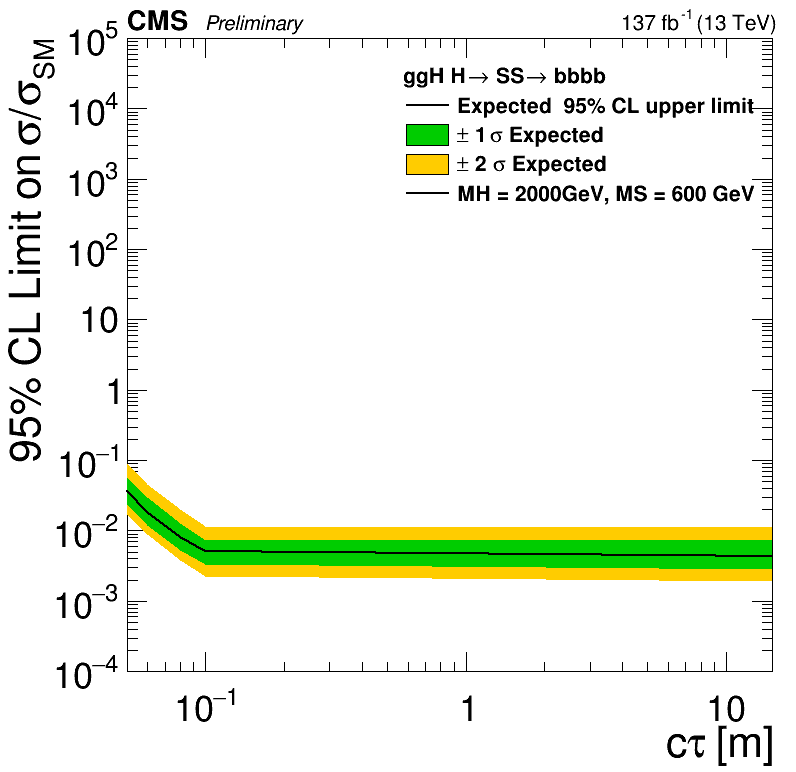

In [62]:
for mH in mHs:
    H = str(mH)
    for mX in mXs[H]:
        X = str(mX)
        
        rt.gStyle.SetOptFit(1011)

        c = rt.TCanvas('c','c', 800, 800)
        leg = rt.TLegend(0.5,0.73,0.80,0.92)
        leg.SetTextSize(0.03)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)

        h_exp = create_TGraph(ctaus_m[H][X], expL[H][X],  axis_title=['c#tau [m]', '95% CL Limit on #sigma/#sigma_{SM}'])

        h_exp1sig = create_TGraph(ctaus_2m[H][X],  exp1sig[H][X])
        h_exp2sig = create_TGraph(ctaus_2m[H][X],  exp2sig[H][X])


        leg.AddEntry(h_exp, "Expected  95% CL upper limit", "L")
        leg.AddEntry(h_exp1sig, "#pm 1 #sigma Expected", 'F')
        leg.AddEntry(h_exp2sig, "#pm 2 #sigma Expected", 'F')
        leg.SetHeader('ggH H#rightarrow SS#rightarrow bbbb')
        leg.AddEntry(h_exp, "MH = "+H+"GeV, MS = "+X+" GeV")
        h_exp.SetLineColor(1)
        h_exp.SetLineWidth(2)
        h_exp1sig.SetFillColor(417)
        h_exp2sig.SetFillColor(800)
        h_exp.GetXaxis().SetLimits(0.05,15.0)
        h_exp.GetYaxis().SetRangeUser(1e-4,1e+5)
        h_exp.GetXaxis().SetTitleOffset(1)

        h_exp.Draw('LA')
        h_exp2sig.Draw( 'Fsame')
        h_exp1sig.Draw('Fsame')
        h_exp.Draw('Lsame')

        tdrstyle.setTDRStyle()
        CMS_lumi.cmsText     = "CMS"
        iPos = 0
        CMS_lumi.writeExtraText = True
        CMS_lumi.extraText   = "Preliminary"

        iPos = 0
        if( iPos==0 ): CMS_lumi.relPosX = 0.12
        CMS_lumi.CMS_lumi(c, 4, 0)
        leg.Draw()
        c.SetRightMargin(0.03)
        c.SetLogy()
        c.SetLogx()

        c.Draw()
        c.SaveAs(LimitPlotDir+'Limit_mH'+H+'_mS'+X+'.png')

137 fb^{-1} (13 TeV)
137 fb^{-1} (13 TeV)
137 fb^{-1} (13 TeV)
137 fb^{-1} (13 TeV)
137 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200901/v1/Limits/Limit_mH400.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200901/v1/Limits/Limit_mH600.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200901/v1/Limits/Limit_mH1000.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200901/v1/Limits/Limit_mH1500.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200901/v1/Limits/Limit_mH2000.png has been created


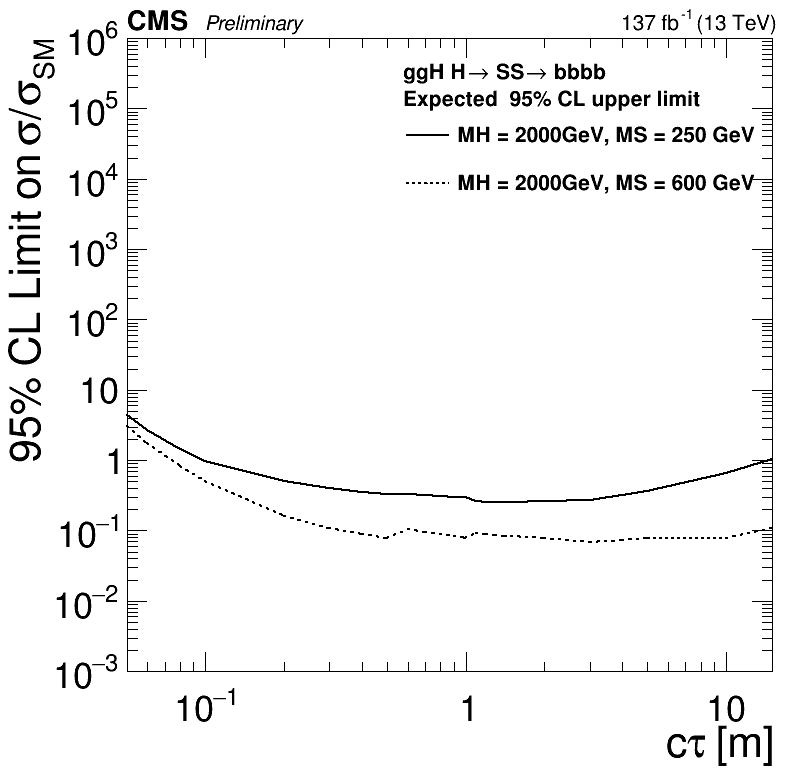

In [147]:
h_exp = {}
h_exp1sig = {}
h_exp2sig = {}

for mH in mHs:
    H = str(mH)

    h_exp[H] = {}
    h_exp1sig[H] = {}
    h_exp2sig[H] = {}
        
    rt.gStyle.SetOptFit(1011)

    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.5,0.73,0.80,0.92)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    cnt=0
    for mX in mXs[H]:
        X = str(mX)
        
        h_exp[H][X] = create_TGraph(ctaus_m[H][X], expL[H][X],  axis_title=['c#tau [m]', '95% CL Limit on #sigma/#sigma_{SM}'])

#         h_exp1sig[H][X] = create_TGraph(ctaus_2m[H][X],  exp1sig[H][X])
#         h_exp2sig[H][X] = create_TGraph(ctaus_2m[H][X],  exp2sig[H][X])
#         leg.AddEntry(h_exp1sig, "#pm 1 #sigma Expected", 'F')
#         leg.AddEntry(h_exp2sig, "#pm 2 #sigma Expected", 'F')

#         leg.AddEntry(h_exp[H][X], "Expected  95% CL upper limit", "L")
#         leg.SetHeader('ggH H#rightarrow SS#rightarrow bbbb')
        leg.SetHeader( '#splitline{ggH H#rightarrow SS#rightarrow bbbb}{Expected  95% CL upper limit}')
        leg.AddEntry(h_exp[H][X], "MH = "+H+"GeV, MS = "+X+" GeV")
        
        h_exp[H][X].SetLineStyle(cnt+1)
        h_exp[H][X].SetLineColor(1)
        h_exp[H][X].SetLineWidth(2)
#         h_exp1sig.SetFillColor(417)
#         h_exp2sig.SetFillColor(800)
        h_exp[H][X].GetXaxis().SetLimits(0.05,15.0)
        h_exp[H][X].GetYaxis().SetRangeUser(1e-3,1e+6)
        h_exp[H][X].GetXaxis().SetTitleOffset(1)

        if cnt==0:
            h_exp[H][X].Draw('LA')
        else:
            h_exp[H][X].Draw('Lsame')
#         h_exp2sig.Draw( 'Fsame')
#         h_exp1sig.Draw('Fsame')
        h_exp[H][X].Draw('Lsame')

        cnt+=1
        
    tdrstyle.setTDRStyle()
    CMS_lumi.cmsText     = "CMS"
    iPos = 0
    CMS_lumi.writeExtraText = True
    CMS_lumi.extraText   = "Preliminary"

    iPos = 0
    if( iPos==0 ): CMS_lumi.relPosX = 0.12
    CMS_lumi.CMS_lumi(c, 4, 0)
    leg.Draw()
    c.SetRightMargin(0.03)
    c.SetLogy()
    c.SetLogx()

    c.Draw()
    c.SaveAs(LimitPlotDir+'Limit_mH'+H+'.png')